# Predicting the Number of Bike Rentals

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
bike_rentals = pd.read_csv('bike_rental_hour.csv')
print(bike_rentals.shape)
bike_rentals.head()

(17379, 17)


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


Text(0.5,0,'Count')

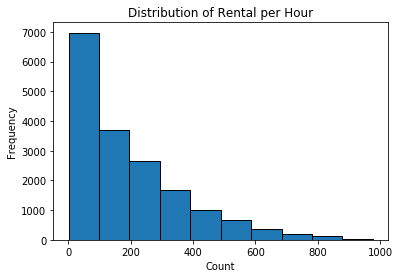

In [3]:
bike_rentals['cnt'].plot.hist(edgecolor="black") #total number of bike rental, casual + registered
plt.title("Distribution of Rental per Hour")
plt.xlabel("Count")

In [4]:
bike_rentals.corr()['cnt'].sort_values(ascending=False)

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
instant       0.278379
yr            0.250495
season        0.178056
mnth          0.120638
windspeed     0.093234
workingday    0.030284
weekday       0.026900
holiday      -0.030927
weathersit   -0.142426
hum          -0.322911
Name: cnt, dtype: float64

In order to better classify our feauture, instead of each hour, we do a categorical classification of the time of rental in a each, with the data being: morning, afternoon, evening, past-midnight.

In [5]:
#convert hour at rental to categorical like:1,2,3,4 (morning, afternoon,evening,night)
def assign_label(row):
    if (row >=6) and (row <12):
        return 1 #le matin
    elif (row >=12) and (row <18):
        return 2 #l'apres midi
    elif (row >=18) and (row < 24):
        return 3 #evening
    elif (row >=0) and (row < 6):
        return 4 #la soiree
    return

bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)

In [6]:
bike_rentals.head(5)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,4
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,4
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,4
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,4
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,4


# To help demonstrate the limited nature of Linear Regression

In [7]:
#we then split the train/test set to 80/20
train = bike_rentals.sample(frac=0.7)
temp_index = bike_rentals.index.isin(train.index) #retrieving indices of our train set
test = bike_rentals.iloc[~temp_index] #not in index

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
features = list(bike_rentals.columns)
features.remove("cnt") #our target
#these are the columns that 'cnt' is derived from. 
#Different types of users who happen to rent bikes on that hour. They add up to'cnt' as we did before
cols = ['casual','dteday','registered']
for i in cols:
    features.remove(i)
    
def linear_model(bike_rentals,features):
    #X_train, X_test, y_train, y_test = train_test_split(bike_rentals[features],bike_rentals["cnt"],test_size=0.8,random_state=1)
    model = LinearRegression()
    model.fit(train[features],train['cnt'])
    hypothesis = model.predict(test[features])

    mse = np.mean((test['cnt'] - hypothesis)**2)
    print(mse)
    print("Mean: ",test['cnt'].mean(),"Stdev: ",test['cnt'].std())
    return mse, hypothesis

mse1,lr1 = linear_model(bike_rentals,features)
print(lr1[:10])
print(test.cnt[:10])

17054.065897475095
Mean:  189.09263521288838 Stdev:  180.63913760628236
[-102.01907385  114.960541    130.51563283  136.86148157  130.87410387
   76.59929308   90.67338984   91.95886163  -89.00089397  -80.95391514]
2      32
9      14
13     94
14    106
15    110
19     37
20     36
22     28
24     17
27      6
Name: cnt, dtype: int64


That's quite a high error, given the fact that our mean is only 188 in the 'cnt' column of test. As we have seen, it's unreasonable that some of the lower values of test carry a negative prediction on such a high swing. Actually, this is understandable since the top 3 parameters with high correlation to "cnt" are actually ["casual","registered","temp"]. Most other parameters after that don't carry as much weight as those. Items such as "weekday", "month" are actually better off as categorical,yet these don't carry as much meaning in Linear Regression.

# Machine Learning Model #2: Decision Tree and Random Forest

In [9]:
#using decision tree to see if it's better than Linear Regression

from sklearn.tree import DecisionTreeRegressor
model2 = DecisionTreeRegressor(min_samples_leaf=8)
model2.fit(train[features],train['cnt'])

hypothesis2 = model2.predict(test[features])
mse2 = np.mean((test['cnt'] - hypothesis2)**2)
print(mse2)

2692.3064029097604


Decision tree seems to be a lot better than Linear Regression. This probably is because the model isn't linear. Then we would expect the decision forest to be better. Also, many of the data aren't continous and aren't meant to be used with Linear Regression. Let's see if Random Forest Regressor will work better also.

In [10]:
from sklearn.ensemble import RandomForestRegressor

model3 = RandomForestRegressor(min_samples_leaf = 8) #same type of trees
model3.fit(train[features],train['cnt'])

hypothesis3 = model3.predict(test[features])
mse3 = np.mean((test['cnt'] - hypothesis3)**2)
print(mse3)
print(mse3**0.5)

2177.7670353789404
46.66655156939433


Since a single tree is prone to overfitting, it's good to see how much more we could've improved with random forest, which are less prone to overfitting. Let's put it together and try to tune the hyperparameters of our RandomForestRegressor Model

In [11]:
from collections import OrderedDict

def rf_model(bike_rentals,features,min_leaf):
    global train, test
    result = OrderedDict()
    for i in range(1,min_leaf):
        model3 = RandomForestRegressor(min_samples_leaf=i) #same type of trees
        model3.fit(train[features],train['cnt'])
        
        hypothesis3 = model3.predict(test[features])
        metric = np.mean((test['cnt'] - hypothesis3)**2)
        result[i] = metric
    return result

rf = rf_model(bike_rentals, features,15)
rf

OrderedDict([(1, 1849.0765630993478),
             (2, 1790.3381899711778),
             (3, 1978.5956126236795),
             (4, 1999.880033649997),
             (5, 1947.8475531252373),
             (6, 2091.8009584911997),
             (7, 2044.6098389561832),
             (8, 2189.0476486341654),
             (9, 2247.4501443473523),
             (10, 2375.543950454255),
             (11, 2252.4625598761804),
             (12, 2423.596224763744),
             (13, 2526.968718398264),
             (14, 2492.287426701438)])

Text(0,0.5,'MSE')

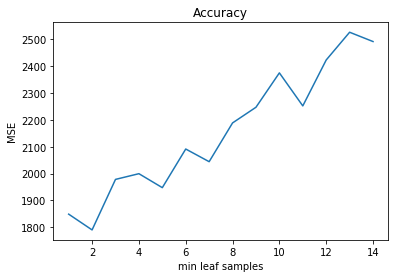

In [12]:
x = [i for i in range(1,15)]
y = []
for key in x:
    y.append(rf[key])
plt.plot(x,y)
plt.title("Accuracy")
plt.xlabel("min leaf samples")
plt.ylabel("MSE")

It is surprising that small number of min leaf samples does not give into overfitting. Seems like the minimum leaf samples is not a hyperparameter we should play with. Let's do a matrix Grid Search

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV

#Grid_search

rf = RandomForestRegressor()
#we'll play with: maximum features to split at a nodes, the number of trees, and the minimum samples leaf for pruning
hyper_params = { 'max_features':np.arange(1,10),'n_estimators':np.arange(5,15),'min_samples_leaf': np.arange(1,10)}
rf_grid = GridSearchCV(rf, hyper_params,scoring="neg_mean_squared_error",n_jobs=-1,cv = 5)
rf_grid.fit(train[features],train["cnt"])


/Library/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Library/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': array([1, 2, 3, 4, 5, 6, 7, 8, 9]), 'n_estimators': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), 'min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
       pre_dispatch='2*n_jobs', refit=True,
       scoring='neg_mean_squared_error', verbose=0)

In [16]:
#obtain best param of grid_search
#print(rf_grid.get_params())
print(rf_grid.best_params_)


{'max_features': 9, 'min_samples_leaf': 1, 'n_estimators': 14}


In [17]:
#derive from Grid_search above, which was commented out for efficiency
def rf_best(bike_rentals,features):    
    rf = RandomForestRegressor(min_samples_leaf=1, max_features=9, n_estimators=14) 
    #doens't seem to be too different from the default
    rf.fit(train[features],train["cnt"])
    hypothesis = rf.predict(test[features])
    metric = np.mean((test['cnt'] - hypothesis)**2)
    return metric
metric = rf_best(bike_rentals,features)
print("MSE: ",metric,"RMSE: ",np.sqrt(metric),"Mean Count :",test.cnt.mean()) #MSE metric

MSE:  1801.6336129964068 RMSE:  42.445654818796314 Mean Count : 189.09263521288838


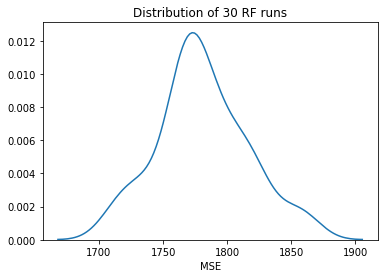

34.46908128832162 1781.0434432480317


In [18]:
#Let's observe the variance and distribution of the metric.
metric = []
for i in range(30):
    metric.append(rf_best(bike_rentals,features))
    rmse = np.sqrt(metric)
sns.kdeplot(metric)
plt.title("Distribution of 30 RF runs")
plt.xlabel("MSE")
plt.show()
print(np.std(metric), np.mean(metric))

Although the mean and stdev are roughly consistent (which is a good thing and doesn't seem to be overfitting), it is really interesting to see that our model doens't always give results in a manner close to a normal distribution. The mean MSE is about ~2000, which is not any meaningful improvement over our default model. However, it is greatly better than the Linear Regression (~17000 unoptimized).

The RMSE of 45 means there's an average offset of 45 counts compared to the mean count of 190. This is due to the outliers we could observed in the histogram at the beginning.

# Machine Learning Model #3: SV Regression

Due to the processing intensity and the need to standardize our data (both nominal and continuous data), we will have to preprocess our data again for this algorithm

In [19]:
from sklearn.svm import SVR
bike_rentals_norm = bike_rentals.copy()
print(bike_rentals_norm.columns)
bike_rentals_norm.dtypes

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt', 'time_label'],
      dtype='object')


instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
time_label      int64
dtype: object

In [20]:
bike_rentals_norm.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,4
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,4
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,4
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,4
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,4


In order to save training time and duplicated information from presenting in our model, we'll drop: instant(index), dteday(not trying to predict the future, just fitting current time), mnth(season encoded), hr (time_label has a division of 4 bins), holiday(semi represented in encoded in workingday) weekday (encoded in workingday), casual(cnt), registered(cnt).

Afterward, we'll do one-hot encoding on: season, and time_label for various nominal categorical data.
weathersit will be normalize to 1-4 as it suggests the good -> bad of weather in term of ordinal datatype. We expect no one to rent a bike when it's raining very heavily
https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset

In [21]:
def season_spring(row):
    if row == 1:
        return 1
    return 0
def season_summer(row):
    if row == 2:
        return 1
    return 0
def season_autumn(row):
    if row == 3:
        return 1
    return 0
def season_winter(row):
    if row == 4:
        return 1
    return 0

bike_rentals_norm["season_sp"] = bike_rentals_norm["season"].apply(season_spring)
bike_rentals_norm["season_su"] = bike_rentals_norm["season"].apply(season_summer)
bike_rentals_norm["season_au"] = bike_rentals_norm["season"].apply(season_autumn)
bike_rentals_norm["season_wi"] = bike_rentals_norm["season"].apply(season_winter)


In [22]:
print(bike_rentals_norm["weathersit"].value_counts()) #our expectation is well-defined
bike_rentals_norm.head()

1    11413
2     4544
3     1419
4        3
Name: weathersit, dtype: int64


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,...,hum,windspeed,casual,registered,cnt,time_label,season_sp,season_su,season_au,season_wi
0,1,2011-01-01,1,0,1,0,0,6,0,1,...,0.81,0.0,3,13,16,4,1,0,0,0
1,2,2011-01-01,1,0,1,1,0,6,0,1,...,0.80,0.0,8,32,40,4,1,0,0,0
2,3,2011-01-01,1,0,1,2,0,6,0,1,...,0.80,0.0,5,27,32,4,1,0,0,0
3,4,2011-01-01,1,0,1,3,0,6,0,1,...,0.75,0.0,3,10,13,4,1,0,0,0
4,5,2011-01-01,1,0,1,4,0,6,0,1,...,0.75,0.0,0,1,1,4,1,0,0,0


In [23]:
bike_rentals_norm = bike_rentals_norm.drop(columns=["instant","dteday","mnth","hr","holiday","weekday","casual","registered"],axis=1)
bike_rentals_norm.head()

,season,yr,workingday,weathersit,temp,atemp,hum,windspeed,cnt,time_label,season_sp,season_su,season_au,season_wi
0,1,0,0,1,0.24,0.2879,0.81,0.0,16,4,1,0,0,0
1,1,0,0,1,0.22,0.2727,0.80,0.0,40,4,1,0,0,0
2,1,0,0,1,0.22,0.2727,0.80,0.0,32,4,1,0,0,0
3,1,0,0,1,0.24,0.2879,0.75,0.0,13,4,1,0,0,0
4,1,0,0,1,0.24,0.2879,0.75,0.0,1,4,1,0,0,0


In [24]:
#Let's observe the time_label to see if there's a definite pattern
bike_rentals_norm.time_label.value_counts()

2    4375
3    4368
1    4360
4    4276
Name: time_label, dtype: int64

In [25]:
def time_dawn(row):
    if row == 1:
        return 1
    return 0
def time_noon(row):
    if row == 2:
        return 1
    return 0
def time_evening(row):
    if row == 3:
        return 1
    return 0
def time_midnight(row):
    if row == 4:
        return 1
    return 0
bike_rentals_norm["time_dawn"] = bike_rentals_norm.time_label.apply(time_dawn)
bike_rentals_norm["time_noon"] = bike_rentals_norm.time_label.apply(time_noon)
bike_rentals_norm["time_evening"] = bike_rentals_norm.time_label.apply(time_evening)
bike_rentals_norm["time_midnight"] = bike_rentals_norm.time_label.apply(time_midnight)

In [26]:
bike_rentals_norm = bike_rentals_norm.drop(columns=["season","time_label"])
bike_rentals_norm.head()

,yr,workingday,weathersit,temp,atemp,hum,windspeed,cnt,season_sp,season_su,season_au,season_wi,time_dawn,time_noon,time_evening,time_midnight
0,0,0,1,0.24,0.2879,0.81,0.0,16,1,0,0,0,0,0,0,1
1,0,0,1,0.22,0.2727,0.80,0.0,40,1,0,0,0,0,0,0,1
2,0,0,1,0.22,0.2727,0.80,0.0,32,1,0,0,0,0,0,0,1
3,0,0,1,0.24,0.2879,0.75,0.0,13,1,0,0,0,0,0,0,1
4,0,0,1,0.24,0.2879,0.75,0.0,1,1,0,0,0,0,0,0,1


In [27]:
#model SVR here, afterward, do a neural network
print(bike_rentals_norm.max())
print(bike_rentals_norm.min())

yr                 1.0000
workingday         1.0000
weathersit         4.0000
temp               1.0000
atemp              1.0000
hum                1.0000
windspeed          0.8507
cnt              977.0000
season_sp          1.0000
season_su          1.0000
season_au          1.0000
season_wi          1.0000
time_dawn          1.0000
time_noon          1.0000
time_evening       1.0000
time_midnight      1.0000
dtype: float64
yr               0.00
workingday       0.00
weathersit       1.00
temp             0.02
atemp            0.00
hum              0.00
windspeed        0.00
cnt              1.00
season_sp        0.00
season_su        0.00
season_au        0.00
season_wi        0.00
time_dawn        0.00
time_noon        0.00
time_evening     0.00
time_midnight    0.00
dtype: float64


In [28]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
target = bike_rentals_norm["cnt"]

temp = scaler.fit_transform(bike_rentals_norm[["weathersit"]])
temp = temp.flatten()
bike_rentals_norm["weathersit_norm"] = temp
bike_rentals_norm["weathersit_norm"].value_counts()
bike_rentals_norm.drop("weathersit",axis=1, inplace=True)
print(bike_rentals_norm.columns)

Index(['yr', 'workingday', 'temp', 'atemp', 'hum', 'windspeed', 'cnt',
       'season_sp', 'season_su', 'season_au', 'season_wi', 'time_dawn',
       'time_noon', 'time_evening', 'time_midnight', 'weathersit_norm'],
      dtype='object')


In [29]:
features = bike_rentals_norm.columns.tolist()
features.remove("cnt")
bike_rentals_norm.head()

,yr,workingday,temp,atemp,hum,windspeed,cnt,season_sp,season_su,season_au,season_wi,time_dawn,time_noon,time_evening,time_midnight,weathersit_norm
0,0,0,0.24,0.2879,0.81,0.0,16,1,0,0,0,0,0,0,1,0.0
1,0,0,0.22,0.2727,0.80,0.0,40,1,0,0,0,0,0,0,1,0.0
2,0,0,0.22,0.2727,0.80,0.0,32,1,0,0,0,0,0,0,1,0.0
3,0,0,0.24,0.2879,0.75,0.0,13,1,0,0,0,0,0,0,1,0.0
4,0,0,0.24,0.2879,0.75,0.0,1,1,0,0,0,0,0,0,1,0.0


In [30]:
#recall
'''
#we then split the train/test set to 80/20
train = bike_rentals.sample(frac=0.7)
temp_index = bike_rentals.index.isin(train.index) #retrieving indices of our train set
test = bike_rentals.iloc[~temp_index] #not in index
'''
temp_index = bike_rentals.index.isin(train.index)
train_norm = bike_rentals_norm.iloc[temp_index]
test_norm = bike_rentals_norm.iloc[~temp_index]

In [35]:
def SVR_model (train_norm, test_norm, features, target,kern):
    svr_rbf = SVR(kernel=kern,C=1e3,gamma=0.5)
    pred = svr_rbf.fit(train_norm[features],train_norm[target]).predict(test_norm[features])
    mse = np.mean((test_norm[target] - pred)**2)
    return mse

rbf_mse = SVR_model(train_norm,test_norm,features,"cnt","rbf")
rbf_mse

12785.412321133626

In [36]:
linear_mse = SVR_model(train_norm,test_norm,features,"cnt","linear")
linear_mse

18727.32131545193

In [37]:
poly_mse = SVR_model(train_norm,test_norm,features,"cnt","poly")
poly_mse

13150.201537430223

We have experienced above values with different kernels and C fudge factor, along with gamma. It turns out that the higher C value the better, and the higher gamma seems to give less MSE. We shall ignore both poly and linear kernels as they don't seem to give better results than the rbf kernel. Let's use grid search to look for the optimal hyperparameters

In [40]:
#since we don't have enough computing power to search, let's just see if we ever will get close to the value of 2k with a rough search
SVR_search = SVR(kernel="rbf")
hyper_params = { 'C':[1e3,1e4,1e5],'gamma':[0.1,0.3,0.7]}
SVR_grid = GridSearchCV(SVR_search, hyper_params,scoring="neg_mean_squared_error",n_jobs=-1, cv=5) #all cores
SVR_grid.fit(train_norm[features],train_norm["cnt"])


KeyboardInterrupt: 

In [ ]:
print(SVR_grid.best_params_)
print(SVR_grid.grid_scores_)

In [ ]:
#use the optimal result of our Grid_search here.
